In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

## Import and Split data

In [3]:
df_features = pd.read_csv('dengue_features_train.csv')
df_labels = pd.read_csv('dengue_labels_train.csv')

In [4]:
data = pd.merge(df_features, df_labels, on = ['city','year','weekofyear'], how = 'left')
data["week_start_date"] = pd.to_datetime(data["week_start_date"])

In [4]:
data.shape

(1456, 25)

In [ ]:
data.info()

In [ ]:
data.isna().sum()

In [5]:
sj = data[data.city == 'sj']
iq = data[data.city == 'iq']

In [6]:
sj = sj.drop(['city','year','weekofyear',],axis=1).set_index('week_start_date')
iq = iq.drop(['city','year','weekofyear',],axis=1).set_index('week_start_date')

In [7]:
print(sj.shape)
print(iq.shape)

(936, 21)
(520, 21)


In [8]:
# 8 : 2 train test split(adjust a bit for forward fillna)
sj_test_size = 190
iq_test_size = 108

sj_train, sj_test = sj[:-sj_test_size], sj[-sj_test_size:]
iq_train, iq_test = iq[:-iq_test_size], iq[-iq_test_size:]

In [10]:
# Forward fill NA values
sj_train.fillna(method='ffill', inplace=True)
iq_train.fillna(method='ffill', inplace=True)

sj_test.fillna(method='ffill', inplace=True)
iq_test.fillna(method='ffill', inplace=True)

In [9]:
sj_labels = sj[['total_cases']]
iq_labels = iq[['total_cases']]

In [12]:
# 分离特征和标签
def split_features_labels(data):
    return data.drop('total_cases', axis=1), data[['total_cases']]

sj_train_features, sj_train_labels = split_features_labels(sj_train)
sj_test_features, sj_test_labels = split_features_labels(sj_test)

iq_train_features, iq_train_labels = split_features_labels(iq_train)
iq_test_features, iq_test_labels = split_features_labels(iq_test)

In [13]:
# print ('San Juan')
# print ('Shape of training features:',sj_train_features.shape)
# print ('Shape of training labels:',sj_train_labels.shape)
# print ('Shape of test features:',sj_test_features.shape)
# print ('Shape of test labels:',sj_test_labels.shape)

# print ('Iquitos')
# print ('Shape of training features:',iq_train_features.shape)
# print ('Shape of training labels:',iq_train_labels.shape)
# print ('Shape of test features:',iq_test_features.shape)
# print ('Shape of test labels:',iq_test_labels.shape)

## Visualization

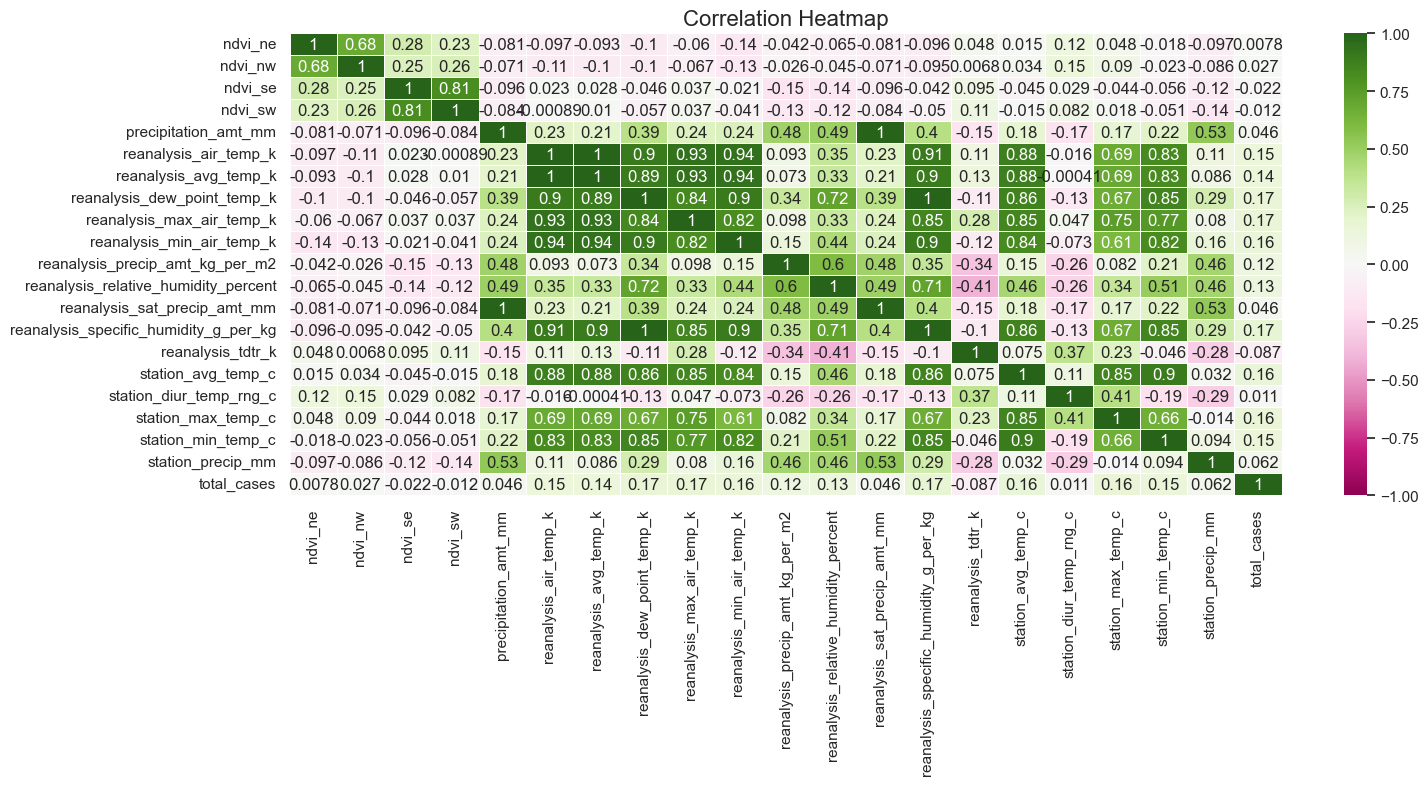

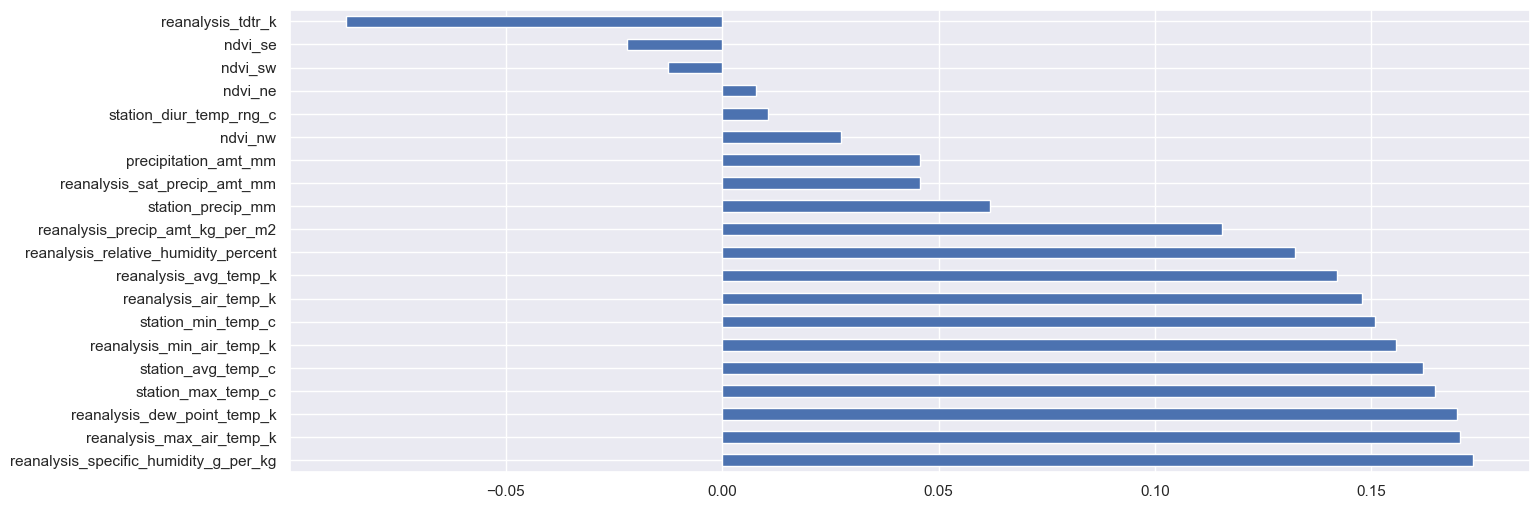

In [9]:
# Plot correlation heatmap and hisotgram
def correlation(df):
    dfcorr = df.corr()
    sns.set(rc={'figure.figsize':(16, 6)})
    sns.heatmap(dfcorr, annot=True, linewidths=.5, vmin=-1, vmax=1, center=0, cmap="PiYG")
    plt.title("Correlation Heatmap", fontsize=16)
    plt.show()
    (dfcorr.total_cases.drop('total_cases').sort_values(ascending=False).plot.barh())
    
correlation(sj_train)

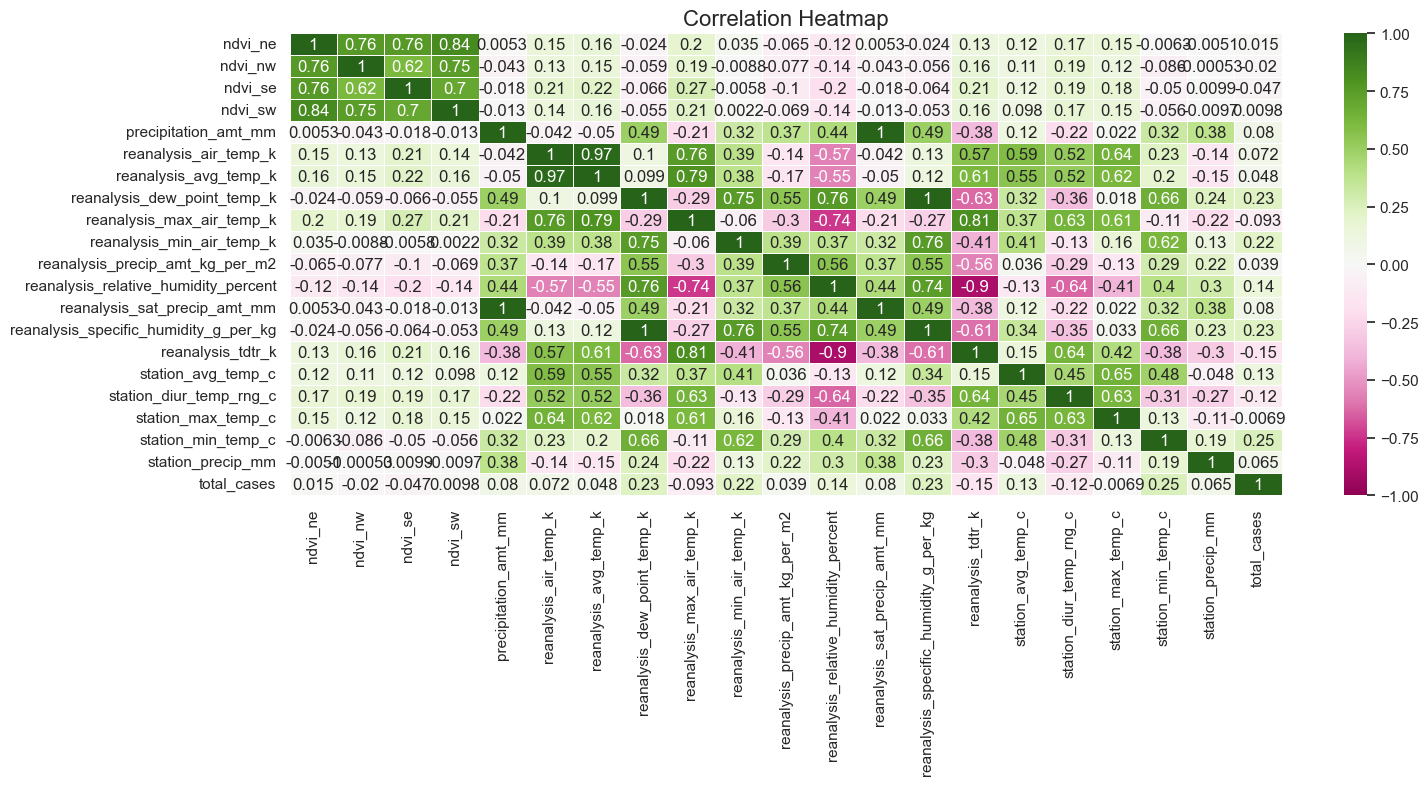

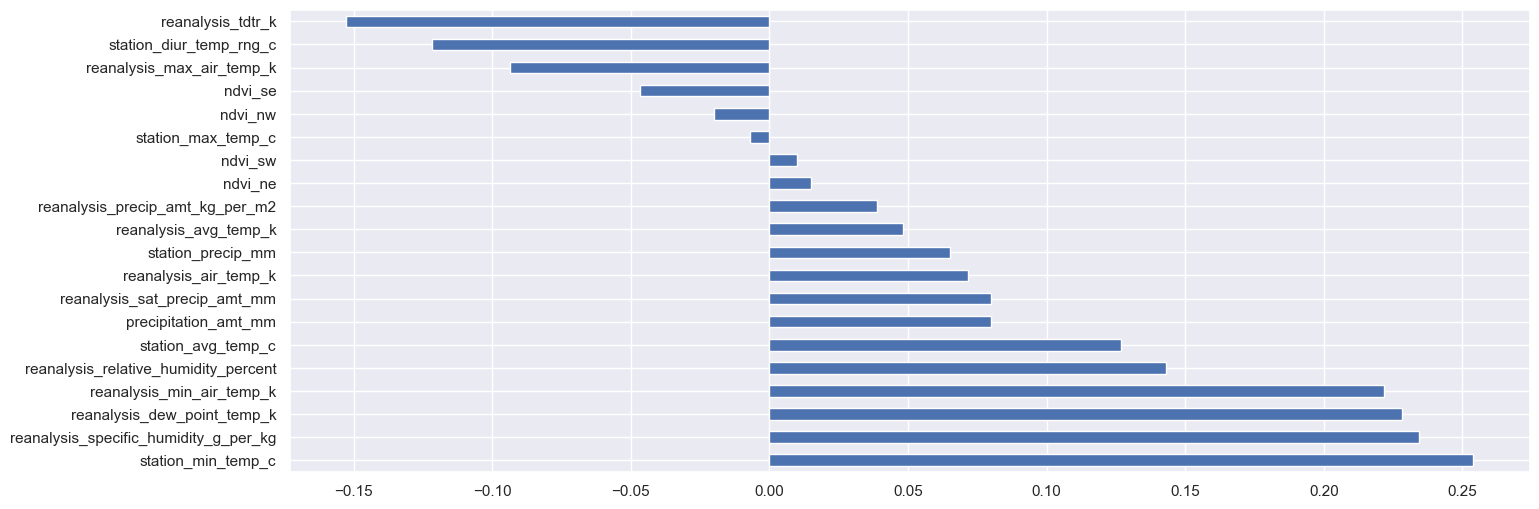

In [10]:
correlation(iq_train)

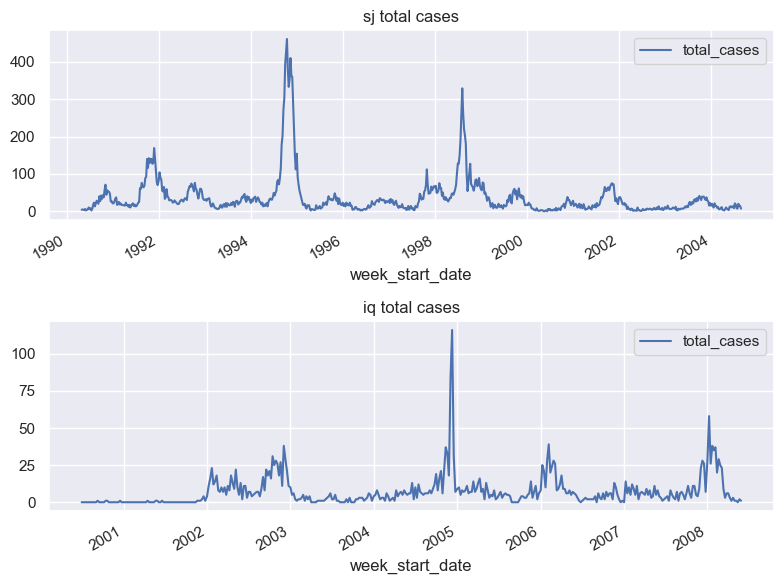

In [108]:
# Plot total cases
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# 在第一个子图中绘制 sj_train_labels
sj_train_labels.plot(ax=axes[0])
axes[0].set_title('sj total cases')

# 在第二个子图中绘制 iq_train_labels
iq_train_labels.plot(ax=axes[1])
axes[1].set_title('iq total cases')

plt.tight_layout()
plt.show()

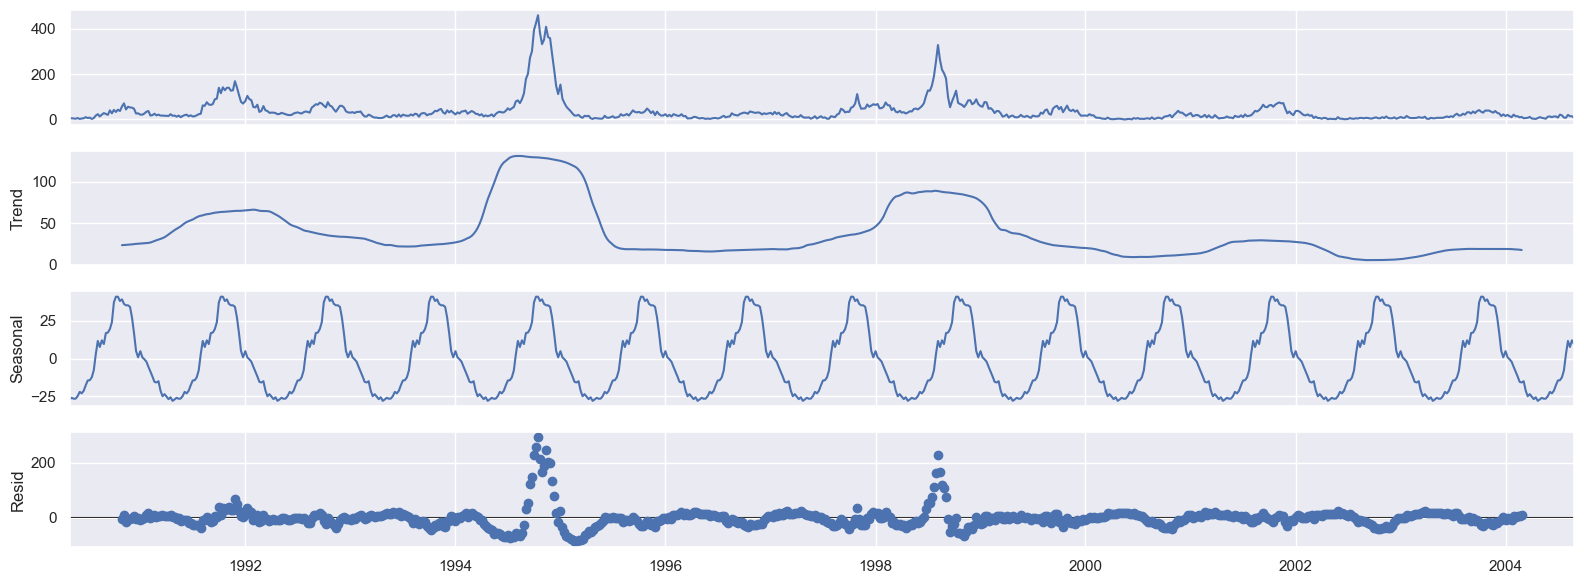

In [109]:
# Decompose sj total cases with period = 52 weeks (1 year)
sj_result = seasonal_decompose(sj_train_labels, period=52)
sj_result.plot()
plt.show()

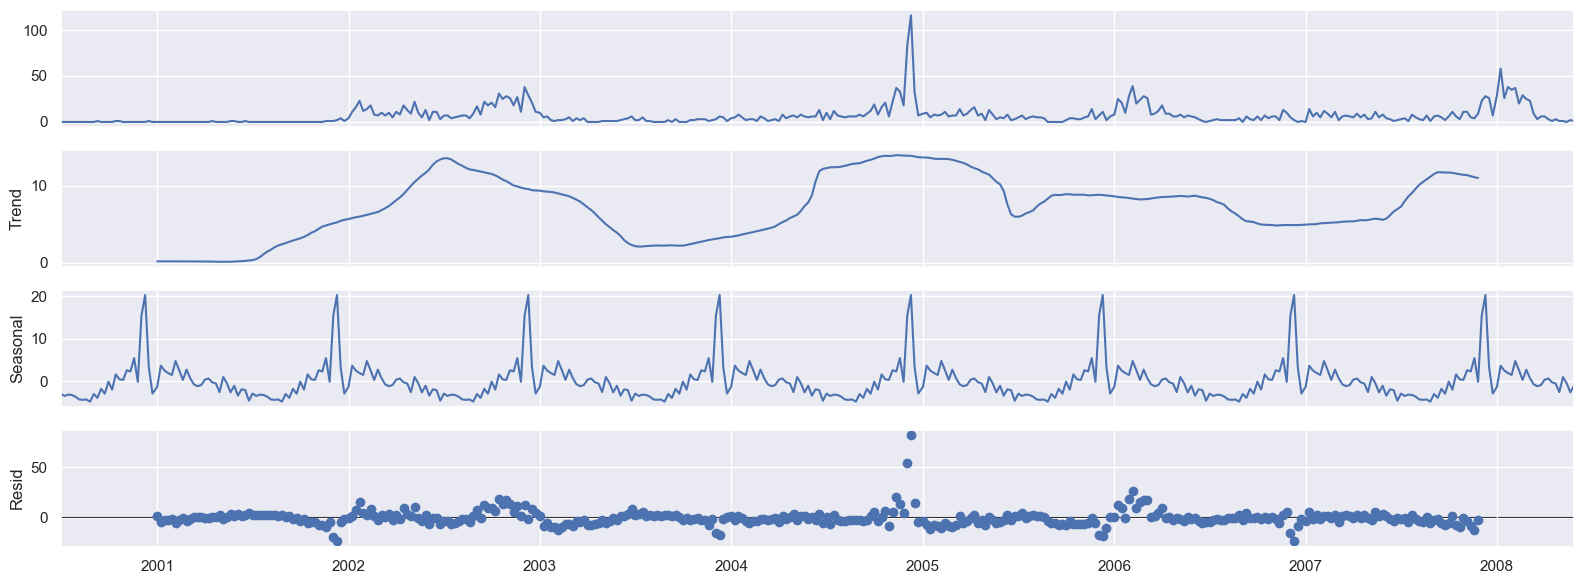

In [110]:
# Also decompose iq data
iq_result = seasonal_decompose(iq_train_labels, period=52)
iq_result.plot()
plt.show()

Noted that total cases in both regions exhibit distinct seasonality, that is why we choose SARIMA rather than ARIMA model.

## SARIMA Modeling

### SJ

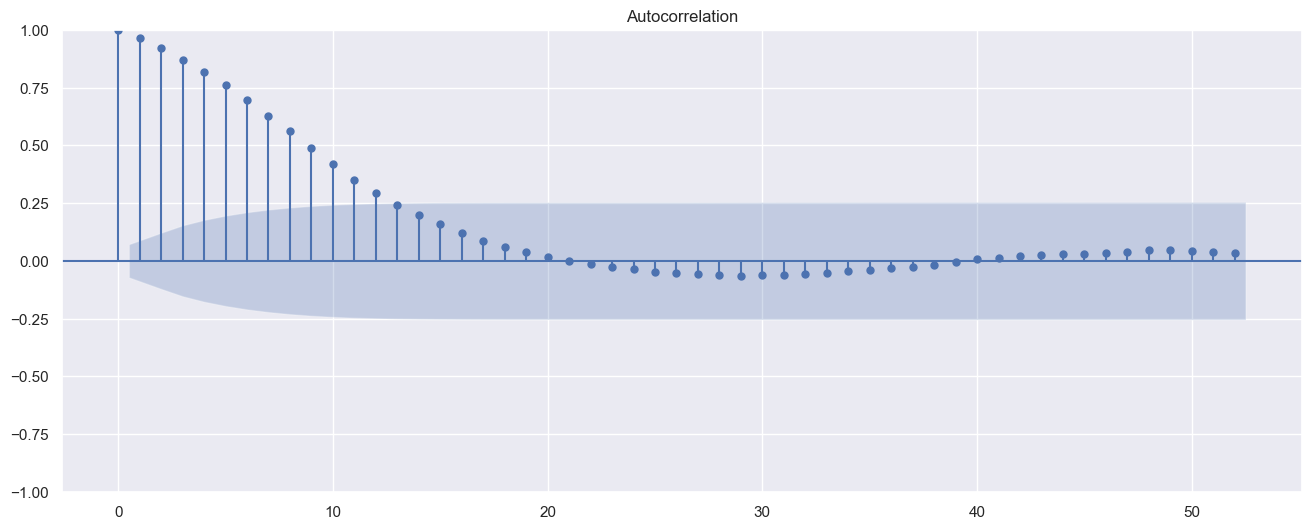

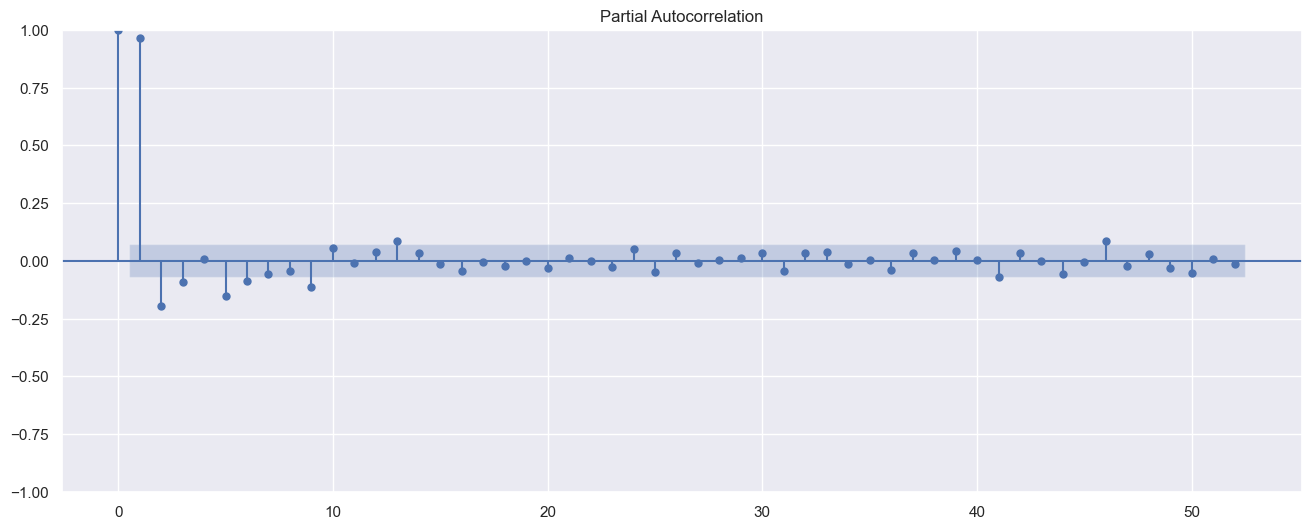

In [120]:
# Plot ACF and PACF
plot_acf(sj_train_labels, lags = 52)
plt.show()
plot_pacf(sj_train_labels, lags = 52)
plt.show()

In [13]:
df_labels = [sj_labels, sj_train_labels, sj_test_labels, iq_labels, iq_train_labels, iq_test_labels]

seasonal_labels = [df.copy().set_index(df.index).to_period('W') for df in df_labels]

sj_labels1, sj_train_labels1, sj_test_labels1, iq_labels1, iq_train_labels1, iq_test_labels1 = seasonal_labels

In [14]:
# Testing For Stationarity

#H0: It is non stationary
#H1: It is stationary
def adf_test(timeseries):
    print ('Dickey-Fuller Test indicates:')
    result = adfuller(timeseries, autolag = None, maxlag = 52)
    outputs = ['Test Statistic','p-value','Lags Used','Number of Observations']
    for value,output in zip(result,outputs):
        print(f'{output} = {value}')
    if result[1] <= 0.05:
        print("Strong evidence to reject H0. Time series has no unit root and is stationary.")
    else:
        print("Weak evidence against H0, time series is non-stationary.")

In [15]:
adf_test(sj_train_labels1)

Dickey-Fuller Test indicates:
Test Statistic = -3.2291488198133496
p-value = 0.018358226606935323
Lags Used = 52
Number of Observations = 693
Strong evidence to reject H0. Time series has no unit root and is stationary.


In [139]:
sj_stepwise = auto_arima(
    sj_train_monthly,
    start_p=0, max_p=2, start_q=0, max_q=2,
    m=12,
    start_P=0, max_P=2, D=1, start_Q=0, max_Q=2,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

sj_stepwise.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1855.966, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1615.129, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1853.970, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1660.789, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1588.410, Time=0.56 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1771.360, Time=0.48 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1551.131, Time=0.67 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1573.081, Time=0.24 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1549.634, Time=0.87 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  173
Model:             SARIMAX(1, 0, 2)x(2, 1, [], 12)   Log Likelihood                -767.516
Date:                             Sat, 04 Nov 2023   AIC                           1547.031
Time:                                     15:27:32   BIC                           1565.520
Sample:                                 04-30-1990   HQIC                          1554.538
                                      - 08-31-2004                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5928      0.061      9.792      0.000       0.474       0.711
ma.L1          0.6844      0.059     11.513      0.000       0.568       0.801
ma.L2          0.2535      0.108      2.339      0.019       0.041       0.466
ar.S.L12      -0.6733      0.053    -12.655      0.000      -0.778      -0.569
ar.S.L24      -0.3563      0.050     -7.059      0.000      -0.455      -0.257
sigma2       768.6819     41.380     18.576      0.000     687.578     849.786
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               630.04
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
sj_model = SARIMAX(sj_train_labels1,
            order=(1, 0, 2),
            seasonal_order=(2, 1, 0, 52))  
            
sj_result = sj_model.fit(method = 'powell')
print(sj_result.summary().tables[1])

Optimization terminated successfully.
         Current function value: 3.897525
         Iterations: 3
         Function evaluations: 212
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9416      0.007    141.095      0.000       0.929       0.955
ma.L1          0.2269      0.026      8.777      0.000       0.176       0.278
ma.L2          0.0777      0.024      3.202      0.001       0.030       0.125
ar.S.L52      -0.6731      0.025    -26.679      0.000      -0.723      -0.624
ar.S.L104     -0.3000      0.024    -12.686      0.000      -0.346      -0.254
sigma2       244.7117      6.932     35.302      0.000     231.125     258.298


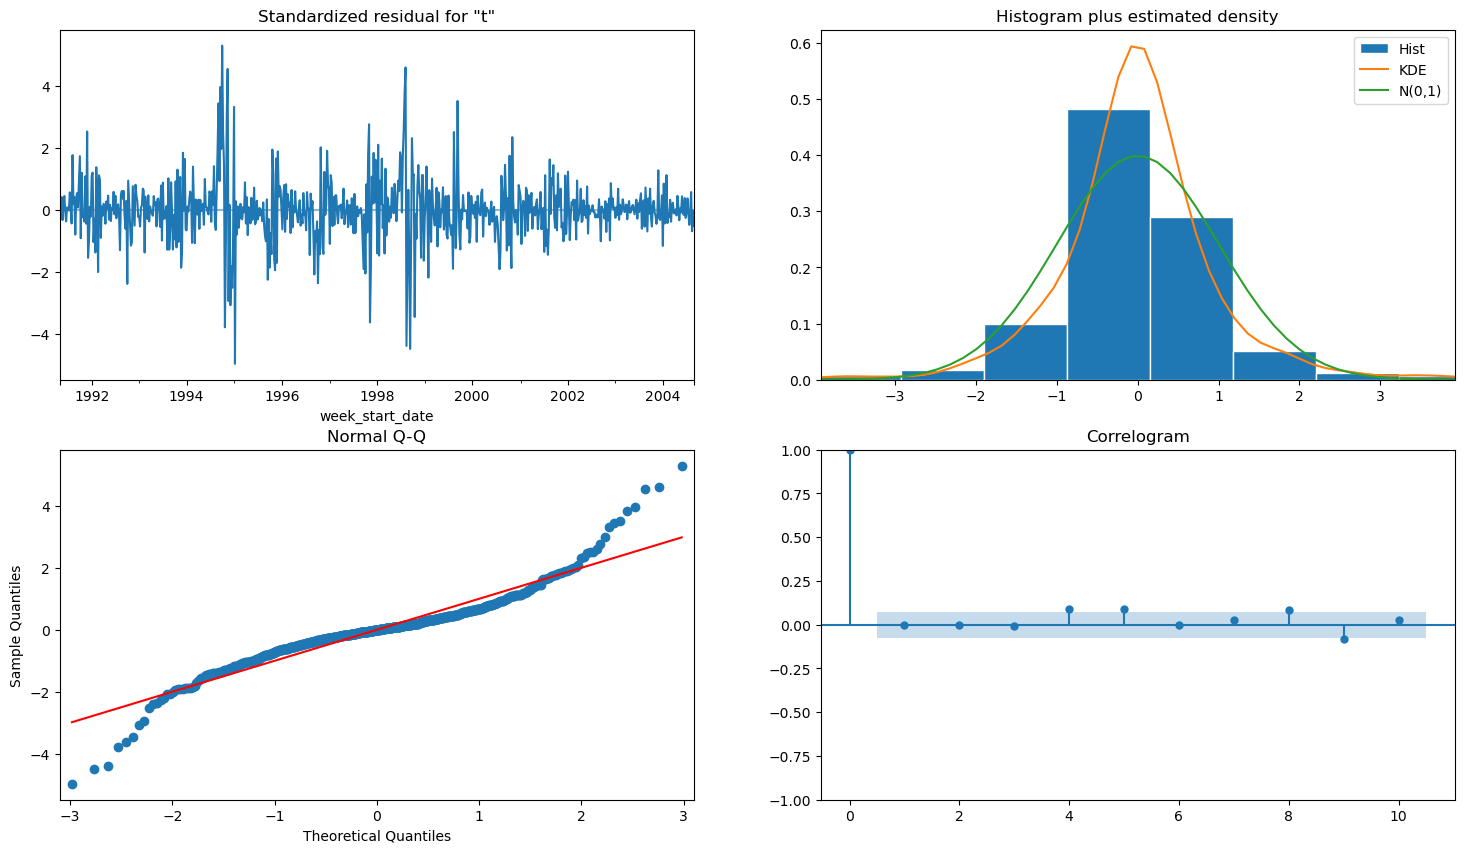

In [30]:
sj_result.plot_diagnostics(figsize=(18, 10))
plt.show()

In [16]:
sj_train_monthly = sj_train_labels.resample('M').mean()
sj_test_monthly = sj_test_labels.resample('M').mean()
iq_train_monthly = iq_train_labels.resample('M').mean()
iq_test_monthly = iq_test_labels.resample('M').mean()

In [17]:
def onestep_fit(train_monthly, test_monthly, order, seasonal_order):
    history = [x for x in train_monthly.values]
    predictions = []

    for t in range(len(test_monthly.values)):

        model = SARIMAX(history, order = order, seasonal_order = seasonal_order)
        model_fit = model.fit(method = 'powell')

        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(float(yhat))
        
        obs = test_monthly.iloc[t]
        history.append(obs)
        
    return predictions

In [18]:
sj_onestep_pred = onestep_fit(sj_train_monthly, sj_test_monthly, (1,0,2), (2, 1, 0, 12))

Optimization terminated successfully.
         Current function value: 4.436526
         Iterations: 3
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: 4.435492
         Iterations: 3
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: 4.434423
         Iterations: 3
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: 4.433715
         Iterations: 3
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: 4.433564
         Iterations: 3
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: 4.432940
         Iterations: 3
         Function evaluations: 220
Optimization terminated successfully.
         Current function value: 4.431948
         Iterations: 3
         Function evaluations: 219
Optimization terminated successful

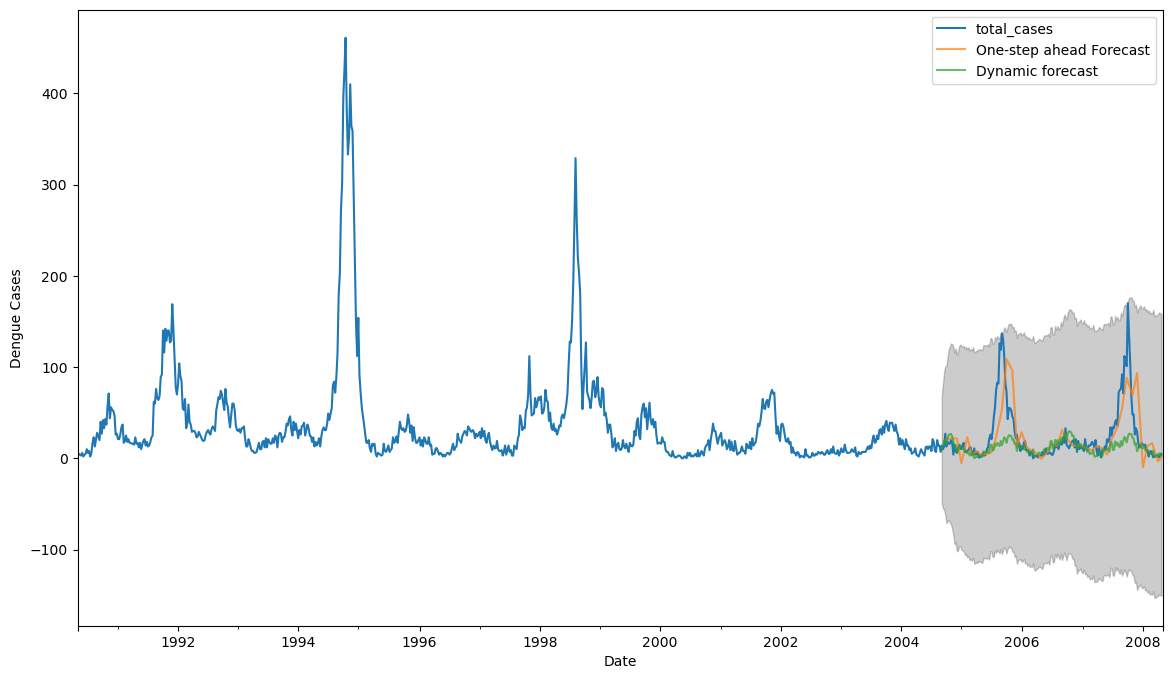

In [31]:
sj_onestep_pred = pd.Series(sj_onestep_pred, index = sj_test_monthly.index.to_period('W'))
sj_dynamic_pred = sj_result.get_prediction(start=pd.to_datetime('2004-09-02').to_period('W'), end = pd.to_datetime('2008-04-22').to_period('W'), dynamic=True)
sj_ci = sj_dynamic_pred.conf_int()
sj_dynamic = sj_dynamic_pred.predicted_mean
ax = sj_labels1.plot(label='observed')
sj_onestep_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 8))
sj_dynamic.plot(ax=ax, label='Dynamic forecast', alpha=.7, figsize=(14, 8))
ax.fill_between(sj_ci.index,
                sj_ci.iloc[:, 0],
                sj_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Dengue Cases')
plt.legend()
plt.show()

In [32]:
sj_dynamic = sj_dynamic.values
sj_truth = sj_test_labels1.values
mae = (abs(sj_dynamic - sj_truth)).mean()
print('The MAE is {}'.format(round(mae, 2)))

The MAE is 19.45


### IQ

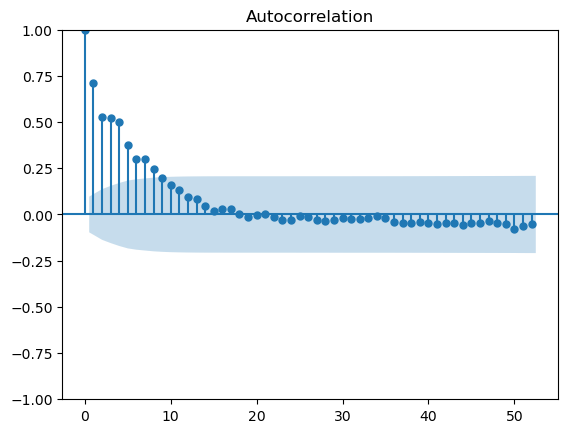

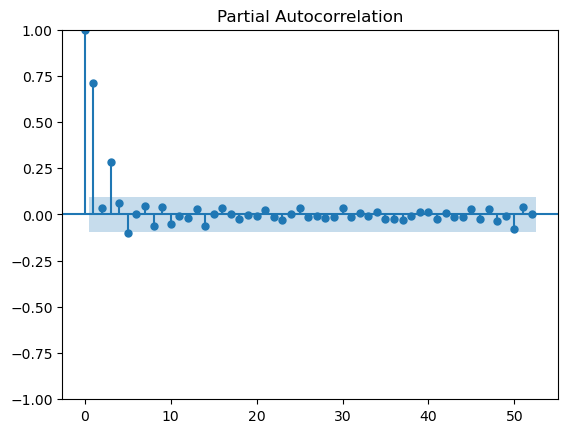

In [39]:
# Plot ACF and PACF
plot_acf(iq_train_labels, lags = 52)
plt.show()
plot_pacf(iq_train_labels, lags = 52)
plt.show()

In [33]:
adf_test(iq_train_labels1)

Dickey-Fuller Test indicates:
Test Statistic = -3.0126980251567494
p-value = 0.03372546057297469
Lags Used = 52
Number of Observations = 359
Strong evidence to reject H0. Time series has no unit root and is stationary.


In [43]:
iq_stepwise = auto_arima(
    iq_train_monthly,
    start_p=0, max_p=3, start_q=0, max_q=3,
    m=12,
    start_P=0, max_P=3, D=1, start_Q=0, max_Q=3,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

iq_stepwise.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=670.041, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=604.418, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=669.132, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=640.605, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=604.157, Time=0.37 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=604.047, Time=0.68 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=627.123, Time=0.53 sec
 ARIMA(2,0,0)(3,1,0)[12] intercept   : AIC=605.809, Time=0.89 sec
 ARIMA(1,0,1)(3,1,0)[12] intercept   : AIC=605.667, Time=0.84 sec
 ARIMA(0,0,1)(3,1,0)[12] intercept   : AIC=606.292, Time=0.66 sec
 ARIMA(2,0,1)(3,1,0)[12] intercept   : AIC=606.963, Time=1.31 sec
 ARIMA(1,0,0)(3,1,0)[12]             : AIC=60

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   95
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -297.409
Date:                            Sat, 04 Nov 2023   AIC                            602.818
Time:                                    15:52:07   BIC                            612.493
Sample:                                07-31-2000   HQIC                           606.705
                                     - 05-31-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5209      0.051     10.241      0.000       0.421       0.621
ar.S.L12      -0.7052      0.077     -9.168      0.000      -0.856      -0.554
ar.S.L24      -0.1644      0.076     -2.165      0.030      -0.313      -0.016
sigma2        70.1627      5.897     11.898      0.000      58.604      81.721
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                94.43
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.73
Prob(H) (two-sided):                  0.10   Kurtosis:                         8.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
iq_model = SARIMAX(iq_train_labels1,
            order = (1, 0, 0),
            seasonal_order=(2, 1, 0, 52))  
            
iq_result = iq_model.fit(method = 'powell') 
print(iq_result.summary().tables[1])

Optimization terminated successfully.
         Current function value: 3.115079
         Iterations: 3
         Function evaluations: 145
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7002      0.010     68.494      0.000       0.680       0.720
ar.S.L52      -0.6669      0.034    -19.533      0.000      -0.734      -0.600
ar.S.L104     -0.2636      0.036     -7.293      0.000      -0.334      -0.193
sigma2        68.1947      1.704     40.025      0.000      64.855      71.534


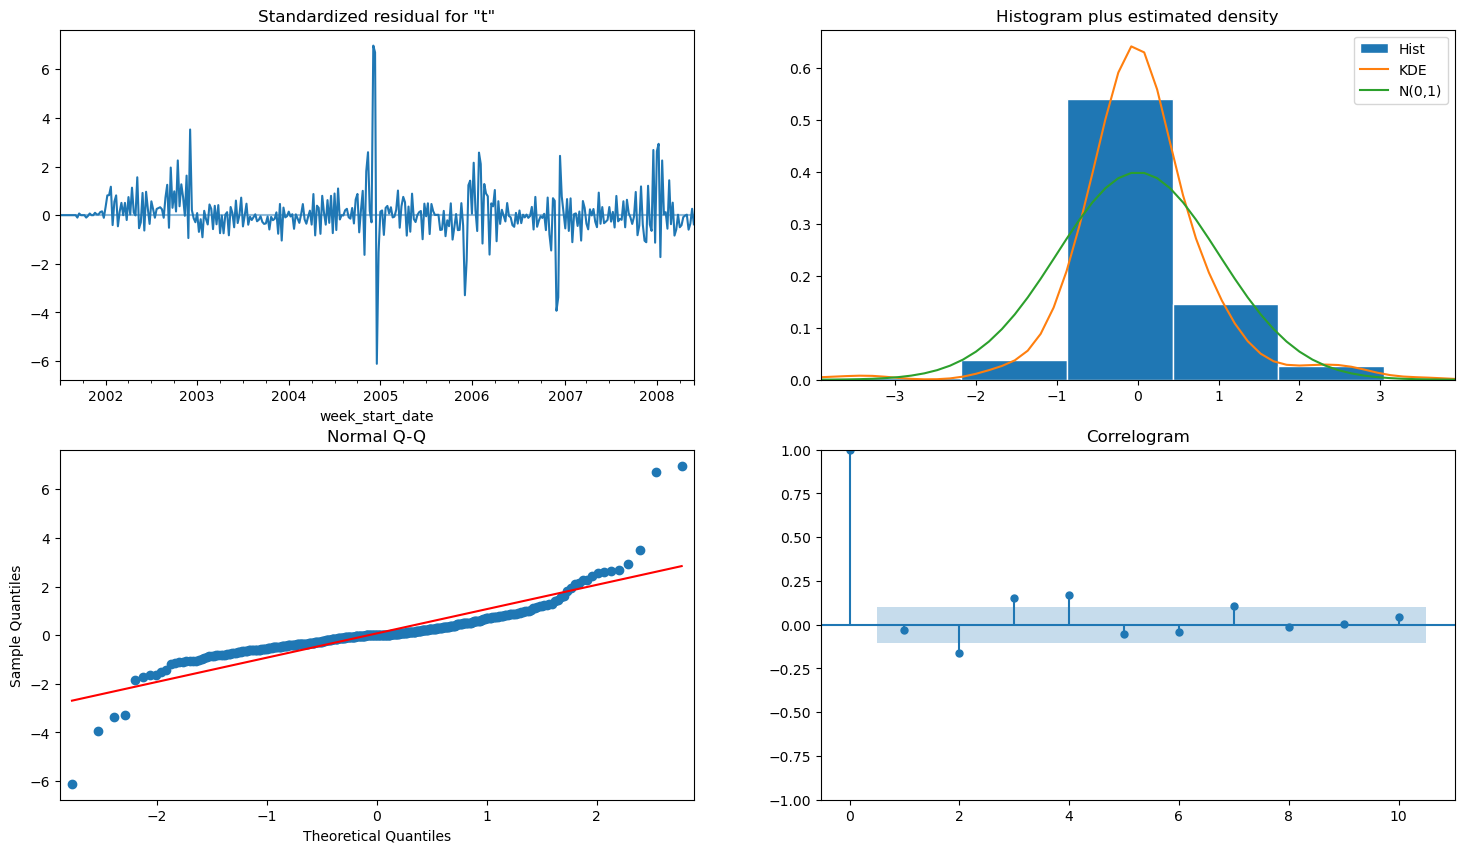

In [45]:
iq_result.plot_diagnostics(figsize=(18, 10))
plt.show()

In [46]:
iq_onestep_pred = onestep_fit(iq_train_monthly, iq_test_monthly, (1,0,0), (2, 1, 0, 12))

Optimization terminated successfully.
         Current function value: 3.130620
         Iterations: 3
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 3.129744
         Iterations: 3
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 3.128779
         Iterations: 3
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 3.127999
         Iterations: 3
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 3.154128
         Iterations: 3
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 3.216096
         Iterations: 3
         Function evaluations: 143
Optimization terminated successfully.
         Current function value: 3.223462
         Iterations: 3
         Function evaluations: 145
Optimization terminated successful

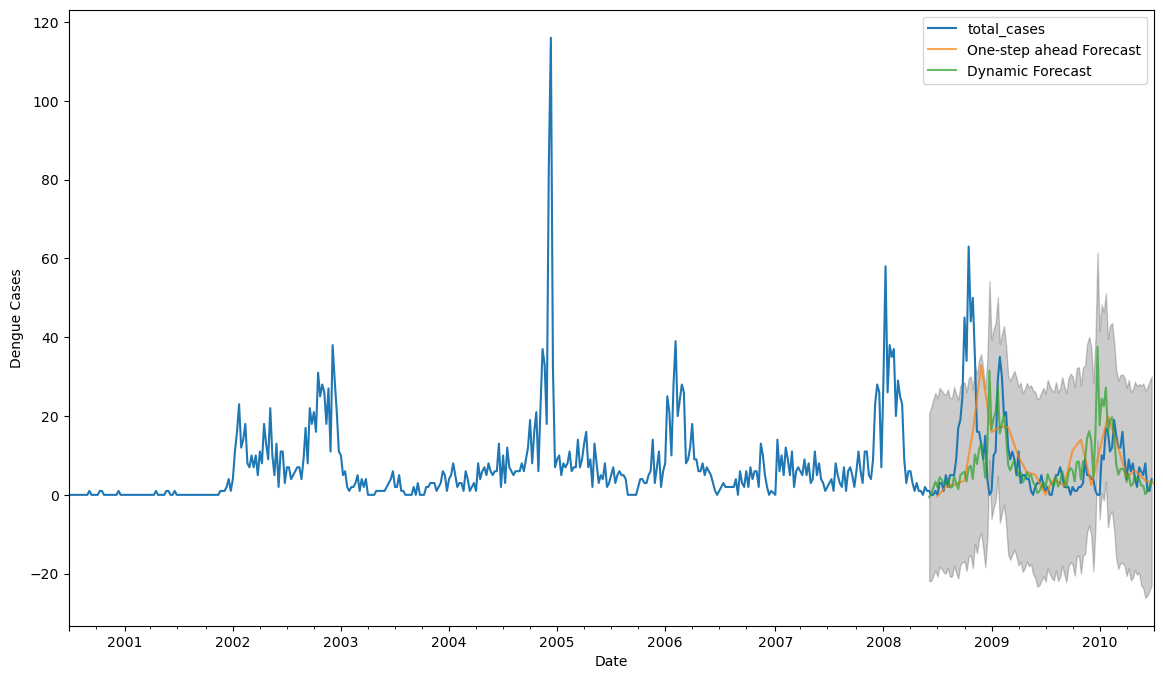

In [47]:
iq_onestep_pred = pd.Series(iq_onestep_pred, index = iq_test_monthly.index.to_period('W'))
iq_dynamic_pred = iq_result.get_prediction(start=pd.to_datetime('2008-06-03').to_period('W'), end = pd.to_datetime('2010-06-25').to_period('W'), dynamic=False)
iq_ci = iq_dynamic_pred.conf_int()
iq_dynamic = iq_dynamic_pred.predicted_mean
ax = iq_labels1.plot(label='observed')
iq_onestep_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 8))
iq_dynamic.plot(ax=ax, label='Dynamic Forecast', alpha=.7, figsize=(14, 8))
ax.fill_between(iq_ci.index,
                iq_ci.iloc[:, 0],
                iq_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Dengue Cases')
plt.legend()
plt.show()

In [48]:
iq_dynamic = iq_dynamic.values
iq_truth = iq_test_labels1.values
#mae = mean_absolute_error(y_truth, y_forecasted)
mae = (abs(iq_dynamic - iq_truth)).mean()
print('The MAE is {}'.format(round(mae, 2)))

The MAE is 8.97
